In [98]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import os
from pydub import AudioSegment

import matplotlib.pyplot as plt
str(torchaudio.get_audio_backend())

'soundfile'

In [99]:
if torch.cuda.is_available():
    # Set the default device to the first available GPU (index 0)
    torch.cuda.set_device(0)
    device = torch.device('cuda')
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4070 Ti


In [66]:
# # convert all mp3 to wav
# genre_folder = r""
# i = 10
#
# for song in os.listdir(genre_folder):
#     song_path = os.path.join(genre_folder, song)
#     audio = AudioSegment.from_mp3(song_path)
#     wav_file_path = os.path.join(genre_folder, str(i) + ".wav")
#     audio.export(wav_file_path, format="wav")
#     i += 1

In [132]:
# block_size = 1 # context length: how many seconds do we take to predict the next one?
# downsample_size = 100
# sample_rate = 44100
# input_size = sample_rate // downsample_size
# target_size = sample_rate // downsample_size
# X = []
# Y = []
#
# for genre in os.listdir("./assets"):
#     for song in os.listdir("./assets/" + genre):
#         if song.endswith(".wav"):
#             waveform = torchaudio.load(os.path.join("./assets", genre, song))[0][0] # get the left channel waveform
#             context = [0] * input_size * block_size
#             for i in range(0, len(waveform) + sample_rate, sample_rate):
#                 one_sec_tensor = waveform[i:i+input_size]
#                 # if len(one_sec_tensor) < input_size:
#                 #     # last second might not be complete, augment with all zeros
#                 #     one_sec_tensor = torch.cat([one_sec_tensor, torch.zeros(44100 - len(one_sec_tensor))])
#
#                 one_sec_list = one_sec_tensor.tolist()[0::downsample_size]
#                 if len(one_sec_list) < input_size:
#                     one_sec_list.extend([0] * (input_size - len(one_sec_list)))
#                 X.append(context)
#                 Y.append(one_sec_list)
#                 context = context[input_size * block_size:] + one_sec_list
#
# X = torch.tensor(X)
# Y = torch.tensor(Y)
# X = X.to(device)
# Y = Y.to(device)
# print("X shape:", X.shape)
# print("Y shape:", Y.shape)


X shape: torch.Size([4944, 441])
Y shape: torch.Size([4944, 441])


In [172]:
genre_to_i = {}
i_to_genre = {}
downsample_size = 2205 # get a sample every 441 samples, resulting 20 per second
sample_rate = 44100
segment_seconds = 5
input_size = sample_rate // downsample_size * segment_seconds
# target_size = sample_rate // downsample_size
X = []
Y_ = []

num_genres = 0
for genre in os.listdir("./assets"):
    genre_to_i[genre] = num_genres

    for song in os.listdir("./assets/" + genre):
        if song.endswith(".wav"):
            waveform = torchaudio.load(os.path.join("./assets", genre, song))[0][0] # get the left channel waveform
            for i in range(0, len(waveform) - sample_rate * segment_seconds, sample_rate * segment_seconds):
                one_sec_tensor = waveform[i:i+sample_rate * segment_seconds]
                one_sec_list = one_sec_tensor.tolist()[0::downsample_size]
                X.append(one_sec_list)
                Y_.append(num_genres)
    num_genres += 1

Y = torch.zeros((len(X), num_genres))
for j in range(len(Y_)):
    Y[j][Y_[j]] += 1
X = torch.tensor(X)

X = X.to(device)
Y = Y.to(device)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: torch.Size([1620, 100])
Y shape: torch.Size([1620, 2])


In [173]:
Y[-1]

tensor([0., 1.], device='cuda:0')

In [174]:
# split the dataset
from torch.utils.data import random_split

# Assuming you have X and Y tensors with shapes:
# X shape: torch.Size([4914, 100])
# Y shape: torch.Size([4914, 3])

# Define the percentages for train, dev, and test sets
train_percent = 0.8
dev_percent = 0.1
test_percent = 0.1

# Calculate the number of samples for each split
num_samples = X.shape[0]
num_train_samples = int(num_samples * train_percent)
num_dev_samples = int(num_samples * dev_percent)
num_test_samples = num_samples - num_train_samples - num_dev_samples

# Create a dataset from X and Y
dataset = torch.utils.data.TensorDataset(X, Y)

# Split the dataset into train, dev, and test sets
train_dataset, dev_dataset, test_dataset = random_split(
    dataset, [num_train_samples, num_dev_samples, num_test_samples]
)

# Create data loaders for each split
batch_size = 64  # Set an appropriate batch size for training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Check the number of samples in each split
print("Number of samples in Xtr, Ytr:", len(train_dataset))
print("Number of samples in Xdev, Ydev:", len(dev_dataset))
print("Number of samples in Xte, Yte:", len(test_dataset))

def extract_input_target(dataset):
    X = torch.stack([sample[0] for sample in dataset])
    Y = torch.stack([sample[1] for sample in dataset])
    return X, Y

# Extract input and target for training dataset
Xtr, Ytr = extract_input_target(train_dataset)

# Extract input and target for development (validation) dataset
Xdev, Ydev = extract_input_target(dev_dataset)

# Extract input and target for test dataset
Xte, Yte = extract_input_target(test_dataset)

Number of samples in Xtr, Ytr: 1296
Number of samples in Xdev, Ydev: 162
Number of samples in Xte, Yte: 162


In [175]:
Xtr

tensor([[ 0.0116, -0.4468,  0.4755,  ...,  0.0660, -0.3575, -0.2663],
        [ 0.2467, -0.2715,  0.1823,  ..., -0.4230,  0.3980,  0.2597],
        [-0.0361, -0.1191,  0.2534,  ...,  0.0563,  0.1633, -0.1313],
        ...,
        [-0.1815, -0.0984,  0.0760,  ..., -0.0739,  0.0781, -0.1923],
        [-0.0145, -0.0252,  0.0339,  ..., -0.1035,  0.1293,  0.0301],
        [ 0.2968, -0.2063,  0.0226,  ...,  0.5928,  0.4333, -0.0491]],
       device='cuda:0')

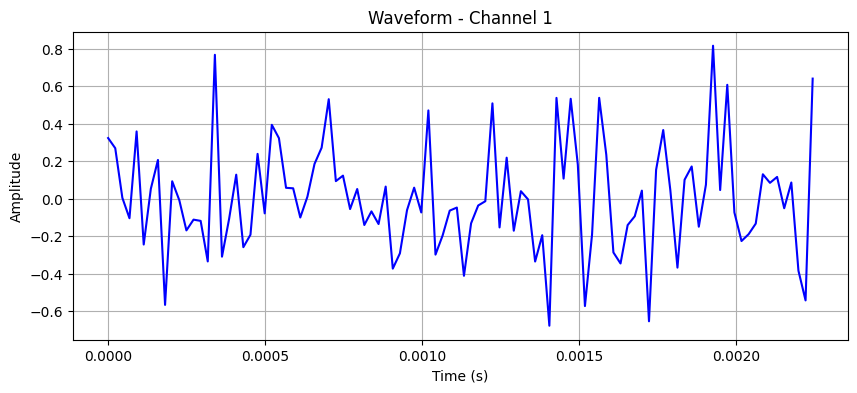

In [176]:
num_samples = 100

# Separate the channels
channel_1 = X[100]

# Create the time axis for plotting (in seconds)
time_axis = torch.arange(0, num_samples) / sample_rate

# Plot Channel 1
plt.figure(figsize=(10, 4))
plt.plot(time_axis.numpy(), channel_1.cpu().numpy(), label="Channel 1", color='b')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform - Channel 1")
plt.grid(True)

plt.show()

In [177]:
# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out, device=device) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim, device=device)
    self.beta = torch.zeros(dim, device=device)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim, device=device)
    self.running_var = torch.ones(dim, device=device)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [178]:
torch.manual_seed(42);

In [201]:
# Create an instance of the model
n_embd = input_size # the dimensionality of the character embedding vectors
n_hidden = 16
model = Sequential([
  # Embedding(X.shape[1], n_embd),
  Linear(n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), nn.ReLU(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), nn.ReLU(),
  # FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, Y.shape[1]),
])
# Print the model architecture
print(model)

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

1954


In [202]:
max_steps = 50000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 #if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  50000: 0.8067
  10000/  50000: 0.0497
  20000/  50000: 0.0053
  30000/  50000: 0.0845
  40000/  50000: 0.1243


In [203]:
for layer in model.layers:
    layer.training = False

In [204]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.014277449809014797
val 3.1891088485717773


In [205]:
def check_success_rate(x, y):
    s = 0
    f = 0
    for i in range(x.shape[0]):
        predict = torch.argmax(model(x[i]))
        actual = torch.argmax(y[i])
        if predict.item() == actual.item():
            s += 1
        else:
            f += 1
    print(s, f)
    return s/(s+f)

In [206]:
check_success_rate(Xdev, Ydev)

97 65


0.5987654320987654

In [207]:
a = torch.argmax(Yte[0])

In [208]:
a.item()

0

In [209]:
Xtr[104]

tensor([ 9.4727e-02,  3.6530e-02,  1.2695e-01, -1.4178e-01,  3.7903e-02,
         9.8724e-02, -1.6479e-02,  8.1024e-02,  1.1444e-02, -2.6184e-02,
         6.8390e-02,  1.2677e-01, -3.1708e-02,  2.1423e-02, -1.6006e-01,
        -2.0874e-02,  4.1870e-02, -1.1392e-01, -1.4423e-01, -1.0892e-01,
        -6.4301e-02, -2.0325e-02, -2.1628e-01,  3.1772e-01, -1.3123e-03,
         1.1786e-01,  3.0212e-02,  1.0275e-01, -1.6113e-02, -8.0109e-02,
        -6.9641e-02, -1.1429e-01,  8.3954e-02, -1.5683e-01,  8.4259e-02,
         3.5553e-02,  3.9276e-02,  6.3477e-03,  8.1177e-03,  1.2756e-02,
        -7.5867e-02,  1.3336e-02, -3.3142e-02,  5.7373e-03,  3.7720e-02,
         7.0801e-02,  4.8615e-02, -1.1591e-01, -3.1189e-02, -2.6947e-02,
        -3.5309e-02,  1.3440e-01, -6.7444e-03,  6.8390e-02,  7.0190e-02,
        -2.7313e-02,  2.0813e-02,  5.3711e-03, -4.3762e-02, -1.8860e-02,
         6.9122e-02,  9.1156e-02,  1.1169e-02, -6.0669e-02,  1.5472e-02,
         8.3588e-02,  1.1322e-02,  3.9032e-02, -1.0

In [141]:
Ytr[104]

tensor([0., 1.], device='cuda:0')